**3D-Cube Orientation**

Class data structure and operations relate
to a Rubik's Cube as in this orientation:

![alt text](rubiks-cube.jpg)
![alt text](rubiks-cube-3D.png)

In [1]:
import math
import numpy as np

# COLORS/SIDES:
WHITE, W  = 1, 1
ORANGE, O = 2, 2
GREEN, G  = 3, 3
RED, R    = 4, 4
BLUE, B   = 5, 5
YELLOW, Y = 6, 6

# COLORS/SIDES in order
SIDES = [WHITE, ORANGE, GREEN, RED, BLUE, YELLOW]

# Print convenience maps/fcns
color_letr_map = { 0:0, WHITE:'W', ORANGE:'O', GREEN:'G', RED:'R', BLUE:'B', YELLOW:'Y' }
color_name_map = { 0:'N/A', WHITE:'WHITE', ORANGE:'ORANGE', GREEN:'GREEN', RED:'RED', BLUE:'BLUE', YELLOW:'YELLOW' }

def color_letr(fc): return color_letr_map[fc]
def color_name(fc): return color_name_map[fc]
def tri_color_name(tc): return (f"({color_letr(tc[0])},{color_letr(tc[1])},{color_letr(tc[2])})")

In [2]:
class Cube3D:
#{
    # Always only
    NCUBELETS = 20
    CLET_KEYS = [(G,O,W),(B,O,W),(B,R,W),(G,R,W),
                 (0,O,W),(B,0,W),(0,R,W),(G,0,W),
                 (G,O,0),(B,O,0),(B,R,0),(G,R,0),
                 (G,O,Y),(B,O,Y),(B,R,Y),(G,R,Y),
                 (0,O,Y),(B,0,Y),(0,R,Y),(G,0,Y)]

    # Access these through static methods below
    _solved_state = {}
    _rotation_matrices = {}

    @staticmethod
    def clet_is_solved(cubelet):
        return sum(cubelet.state() == Cube3D.solved_state(cubelet)) == 12
    
    @staticmethod
    def get_clet_index(tri_color):
        return next(i for i in range(len(Cube3D.CLET_KEYS)) if Cube3D.CLET_KEYS[i] == tri_color) 
    
    @staticmethod
    def solved_state(cubelet):
    #{
        if not Cube3D._solved_state:
        #{
            # Model input encoding formats of solved-state per cubelet
            Cube3D._solved_state[(G,O,W)] = np.array([1,-1,1,1,0,0,0,-1,0,0,0,1])
            Cube3D._solved_state[(B,O,W)] = np.array([-1,-1,1,-1,0,0,0,-1,0,0,0,1])
            Cube3D._solved_state[(B,R,W)] = np.array([-1,1,1,-1,0,0,0,1,0,0,0,1])
            Cube3D._solved_state[(G,R,W)] = np.array([1,1,1,1,0,0,0,1,0,0,0,1])
            Cube3D._solved_state[(0,O,W)] = np.array([0,-1,1,0,0,0,0,-1,0,0,0,1])
            Cube3D._solved_state[(B,0,W)] = np.array([-1,0,1,-1,0,0,0,0,0,0,0,1])
            Cube3D._solved_state[(0,R,W)] = np.array([0,1,1,0,0,0,0,1,0,0,0,1])
            Cube3D._solved_state[(G,0,W)] = np.array([1,0,1,1,0,0,0,0,0,0,0,1])
            Cube3D._solved_state[(G,O,0)] = np.array([1,-1,0,1,0,0,0,-1,0,0,0,0])
            Cube3D._solved_state[(B,O,0)] = np.array([-1,-1,0,-1,0,0,0,-1,0,0,0,0])
            Cube3D._solved_state[(B,R,0)] = np.array([-1,1,0,-1,0,0,0,1,0,0,0,0])
            Cube3D._solved_state[(G,R,0)] = np.array([1,1,0,1,0,0,0,1,0,0,0,0])
            Cube3D._solved_state[(G,O,Y)] = np.array([1,-1,-1,1,0,0,0,-1,0,0,0,-1])
            Cube3D._solved_state[(B,O,Y)] = np.array([-1,-1,-1,-1,0,0,0,-1,0,0,0,-1])
            Cube3D._solved_state[(B,R,Y)] = np.array([-1,1,-1,-1,0,0,0,1,0,0,0,-1])
            Cube3D._solved_state[(G,R,Y)] = np.array([1,1,-1,1,0,0,0,1,0,0,0,-1])
            Cube3D._solved_state[(0,O,Y)] = np.array([0,-1,-1,0,0,0,0,-1,0,0,0,-1])
            Cube3D._solved_state[(B,0,Y)] = np.array([-1,0,-1,-1,0,0,0,0,0,0,0,-1])
            Cube3D._solved_state[(0,R,Y)] = np.array([0,1,-1,0,0,0,0,1,0,0,0,-1])
            Cube3D._solved_state[(G,0,Y)] = np.array([1,0,-1,1,0,0,0,0,0,0,0,-1])
        #}
        
        return Cube3D._solved_state[cubelet.colors]
    #}
    
    @staticmethod
    def rotation(side_angle_tuple):
    #{
        if not Cube3D._rotation_matrices:
        #{
            # Rotation matrix mappings
            for rad, deg in zip([math.pi/2, -math.pi/2, math.pi], [90, -90, 180]):
            #{
                c = round(math.cos(rad))
                s = round(math.sin(rad))

                Rx = np.array([[1,0,0],[0,c,-s],[0,s,c]])
                Ry = np.array([[c,0,s],[0,1,0],[-s,0,c]])
                Rz = np.array([[c,-s,0],[s,c,0],[0,0,1]])

                Cube3D._rotation_matrices[(GREEN,deg)]  = Rx
                Cube3D._rotation_matrices[(BLUE,deg)]   = Rx
                Cube3D._rotation_matrices[(RED,deg)]    = Ry
                Cube3D._rotation_matrices[(ORANGE,deg)] = Ry
                Cube3D._rotation_matrices[(WHITE,deg)]  = Rz
                Cube3D._rotation_matrices[(YELLOW,deg)] = Rz
            #}
        #}
        
        return Cube3D._rotation_matrices[side_angle_tuple]
    #}
        
    # Inner class
    class Cubelet:
    #{
        def __init__(self, colors, position, orient=None):
        #{
            self.colors = colors
            self.position = position
            
            if orient is not None: self.orient = orient
            else: self.orient = np.array([[position[0],0,0],[0,position[1],0],[0,0,position[2]]]).transpose()
            
            # Defining: x_dim = 0, y_dim = 1, z_dim = 2 (i.e. position = [x,y,z])
            self._side_dim_map = { GREEN:0, BLUE:0, RED:1, ORANGE:1, WHITE:2, YELLOW:2 }
            self._side_dir_map = { GREEN:1, BLUE:-1, RED:1, ORANGE:-1, WHITE:1, YELLOW:-1 }
        #}
        
        def __repr__(self): 
            return (f"colors: {self.name()}\n"
                    f"position: {self.position}\n"
                    f"orientation:\n {self.orient}")
        
        def __eq__(self, other):
            return self.colors == other.colors
        
        def copy(self):
            return Cube3D.Cubelet(colors=self.colors, position=self.position, orient=self.orient)
        
        def matches(self, other):
            return (self == other and self.isat(other.position) and self.isorient(other.orient))
        
        def name(self):
            return (f"({color_letr(self.colors[0])},"
                    f"{color_letr(self.colors[1])},"
                    f"{color_letr(self.colors[2])})")
        
        def state(self):
            return np.concatenate((self.position, self.orient), axis=None)

        def ison(self, side):
            return self.position[self._side_dim_map[side]] == self._side_dir_map[side]
        
        def isat(self, position):
            return sum(self.position == position) == 3
                
        def isorient(self, orient):
            return sum(sum(self.orient == orient)) == 9
        
        def colorat(self, side):         
            sdim_row = self.orient[self._side_dim_map[side],:]
            return self.colors[np.flatnonzero(sdim_row == self._side_dir_map[side])[0]]
        
        def reset(self, state_v):
            state_v = np.ndarray.flatten(state_v)
            self.position = np.array(state_v[0:3])
            self.orient = np.array(state_v[3:].reshape(3,3))
        
        # NOTE: this is a direct apply, check
        # that ison(side) is client responsibility
        def apply_rotation(self, R):
            self.position = R.dot(self.position)
            self.orient = R.dot(self.orient)
    #}
    
    # Begin Cube3D implementation
    def __init__(self, copycube=None):
    #{
        if copycube is None:
        #{
            self.cubelets = []
            
            # Top layer
            self.cubelets.append(self.Cubelet(colors=(G,O,W), position=np.array([1,-1,1])))
            self.cubelets.append(self.Cubelet(colors=(B,O,W), position=np.array([-1,-1,1])))
            self.cubelets.append(self.Cubelet(colors=(B,R,W), position=np.array([-1,1,1])))
            self.cubelets.append(self.Cubelet(colors=(G,R,W), position=np.array([1,1,1])))
            self.cubelets.append(self.Cubelet(colors=(0,O,W), position=np.array([0,-1,1])))
            self.cubelets.append(self.Cubelet(colors=(B,0,W), position=np.array([-1,0,1])))
            self.cubelets.append(self.Cubelet(colors=(0,R,W), position=np.array([0,1,1])))
            self.cubelets.append(self.Cubelet(colors=(G,0,W), position=np.array([1,0,1])))

            # Middle layer
            self.cubelets.append(self.Cubelet(colors=(G,O,0), position=np.array([1,-1,0])))
            self.cubelets.append(self.Cubelet(colors=(B,O,0), position=np.array([-1,-1,0])))
            self.cubelets.append(self.Cubelet(colors=(B,R,0), position=np.array([-1,1,0])))
            self.cubelets.append(self.Cubelet(colors=(G,R,0), position=np.array([1,1,0])))

            # Bottom layer
            self.cubelets.append(self.Cubelet(colors=(G,O,Y), position=np.array([1,-1,-1])))
            self.cubelets.append(self.Cubelet(colors=(B,O,Y), position=np.array([-1,-1,-1])))
            self.cubelets.append(self.Cubelet(colors=(B,R,Y), position=np.array([-1,1,-1])))
            self.cubelets.append(self.Cubelet(colors=(G,R,Y), position=np.array([1,1,-1])))
            self.cubelets.append(self.Cubelet(colors=(0,O,Y), position=np.array([0,-1,-1])))
            self.cubelets.append(self.Cubelet(colors=(B,0,Y), position=np.array([-1,0,-1])))
            self.cubelets.append(self.Cubelet(colors=(0,R,Y), position=np.array([0,1,-1])))
            self.cubelets.append(self.Cubelet(colors=(G,0,Y), position=np.array([1,0,-1])))
        #}
        else: self.cubelets = [copylet.copy() for copylet in copycube.cubelets]
    #}
    
    def get_cubelet(self, cubelet):
        return next(clet for clet in self.cubelets if clet == cubelet)
    
    def get_cubelets(self, side):
        return [clet for clet in self.cubelets if clet.ison(side)]
    
    def get_colorat(self, side, position):
    #{
        # Cubelet will default to None if position is one of the 6 fixed centers 
        cubelet = next((clet for clet in self.cubelets if clet.isat(position)), None)
        return side if cubelet is None else cubelet.colorat(side)
    #}
    
    def numb_solved(self):
        return sum([Cube3D.clet_is_solved(clet) for clet in self.cubelets])
    
    def is_solved(self):
        return self.numb_solved() == Cube3D.NCUBELETS

    def state(self):
        return np.concatenate([cubelet.state() for cubelet in self.cubelets])
    
    def reset(self):
        for clet in self.cubelets: clet.reset(Cube3D.solved_state(clet))
      
    def scramble(self, sz=64):
    #{
        self.reset() # Start from solved/reset state
        angle = np.random.choice([90, -90, 180], size=sz)
        sides = np.random.randint(low=1, high=7, size=sz)
        for sd, ang in zip(sides, angle): self.rotate(sd,ang)
    #}
    
    def rotate(self, side, angle):
        for clet in self.get_cubelets(side): clet.apply_rotation(Cube3D.rotation((side, angle)))
#}

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.colors as mpc

# Plotting color map
color_plot_map = { WHITE: mcd.CSS4_COLORS['ivory'],
                   ORANGE: mcd.XKCD_COLORS['xkcd:orange'].upper(), 
                   GREEN: mcd.CSS4_COLORS['green'],
                   RED: mcd.XKCD_COLORS['xkcd:crimson'].upper(),
                   BLUE: mcd.XKCD_COLORS['xkcd:blue'].upper(),
                   YELLOW: mcd.XKCD_COLORS['xkcd:goldenrod'].upper() }

def color(fc): return color_plot_map[fc]

In [29]:
class Cube3DView:
#{
    OFFSET     = 130
    CENTERS    = np.array([[0,0,1],[0,-1,0],[1,0,0],[0,1,0],[-1,0,0],[0,0,-1]])
    ANCHOR_POS = { WHITE:(40,70), ORANGE:(10,40), GREEN:(40,40), RED:(70,40), BLUE:(100,40), YELLOW:(40,10) }
    DRAW_ORDER = { WHITE:  np.array([[-1,-1,1],[-1,0,1],[-1,1,1],[0,-1,1],[0,0,1],[0,1,1],[1,-1,1],[1,0,1],[1,1,1]]),
                   ORANGE: np.array([[-1,-1,1],[0,-1,1],[1,-1,1],[-1,-1,0],[0,-1,0],[1,-1,0],[-1,-1,-1],[0,-1,-1],[1,-1,-1]]),
                   GREEN:  np.array([[1,-1,1],[1,0,1],[1,1,1],[1,-1,0],[1,0,0],[1,1,0],[1,-1,-1],[1,0,-1],[1,1,-1]]),
                   RED:    np.array([[1,1,1],[0,1,1],[-1,1,1],[1,1,0],[0,1,0],[-1,1,0],[1,1,-1],[0,1,-1],[-1,1,-1]]),
                   BLUE:   np.array([[-1,1,1],[-1,0,1],[-1,-1,1],[-1,1,0],[-1,0,0],[-1,-1,0],[-1,1,-1],[-1,0,-1],[-1,-1,-1]]),
                   YELLOW: np.array([[1,-1,-1],[1,0,-1],[1,1,-1],[0,-1,-1],[0,0,-1],[0,1,-1],[-1,-1,-1],[-1,0,-1],[-1,1,-1]]) }

    def __init__(self, cube3D):
        self.cube3D = cube3D
        self.patch_sequence = [[]]
        self.caption_sequence = [[]]
    
    def reset_snapshots(self):
        self.patch_sequence = []
        self.caption_sequence = []
    
    def iscenter(self, position):
        return next((True for cent in self.CENTERS if sum(cent == position) == 3), False)
    
    def get_gray_mask(self, side, cubelet):
    #{
        mask = []
        for pos in self.DRAW_ORDER[side]:
            mask.append('color' if self.iscenter(pos) or cubelet.isat(pos) else 'gray')
        
        return np.reshape(mask, (3,3))
    #}    
    
    def get_plot_rects(self, faces, anchor=(0,0), mask=None):
    #{    
        rects = []
        for r in range(3):
            for c in range(3):
                
                x = anchor[0] + (c*10)
                y = anchor[1] + 20  - (r*10)
                clr = color(faces[r,c])
                
                if mask is not None and (mask[r,c] == 'gray'):
                    g = np.mean(mpc.to_rgb(clr)) * 0.667
                    clr = mpc.to_hex((g,g,g))
                  
                rects.append(plt.Rectangle((x, y), 10, 10, fc=clr))

        return rects
    #}
    
    def get_gridlines(self, seqnumb=0):
    #{
        lines = []            
        for anchor in [(40,70), (10,40), (40,40), (70,40), (100,40), (40,10)]:
        #{
            xoff = self.OFFSET * seqnumb
        
            for r in range(4):
                y = anchor[1] + (r*10)
                lines.append(plt.Line2D((anchor[0] + xoff, anchor[0] + xoff + 30), (y, y), lw=1, color='k'))

            for c in range(4):
                x = anchor[0] + xoff + (c*10)
                lines.append(plt.Line2D((x, x), (anchor[1], anchor[1] + 30), lw=1, color='k'))
        #}
        
        return lines
    #}
    
    def create_patches(self, cubelet=None, seqnumb=0):
    #{
        rects = []
        mask = None
        
        for side in SIDES:
            if cubelet is not None: mask = self.get_gray_mask(side, self.cube3D.get_cubelet(cubelet))
            anchor = (self.ANCHOR_POS[side][0] + (self.OFFSET * seqnumb), self.ANCHOR_POS[side][1])
            faces = [self.cube3D.get_colorat(side, position) for position in self.DRAW_ORDER[side]]
            rects.extend(self.get_plot_rects(np.reshape(faces, (3,3)), anchor, mask))
        
        return rects
    #}
    
    # Displays a single cube projection
    def draw_projection(self, cubelet=None):
    #{
        fig = plt.figure(figsize=[4, 3])
        ax = fig.add_axes([0, 0, 1, 1])
        
        rects = self.create_patches(cubelet)
        for r in rects: ax.add_patch(r)
        for ln in self.get_gridlines(): ax.add_line(ln)
 
        ax.axis('scaled')
        ax.axis('off')
        plt.show()
    #}
    
    def push_snapshot(self, cubelet=None, caption=""):
    #{
        # Adjust to 5 cube images per row
        top = len(self.patch_sequence)-1
        if len(self.patch_sequence[top]) > 4:
            self.caption_sequence.append([])
            self.patch_sequence.append([])
            top = len(self.patch_sequence)-1

        seqnumb = len(self.patch_sequence[top])
        rects = self.create_patches(cubelet, seqnumb)
        self.patch_sequence[top].append(rects)
        self.caption_sequence[top].append(caption)
    #}
    
    # Displays a move sequence
    def draw_snapshops(self):
    #{
        for row in range(len(self.patch_sequence)):
        #{
            nmoves = len(self.patch_sequence[row])
            width = (4 * nmoves) + (nmoves - 1)
            fig = plt.figure(figsize=[width, 3])
            ax = fig.add_axes([0, 0, 1, 1])

            for seqnumb in range(len(self.patch_sequence[row])):
            #{
                rects = self.patch_sequence[row][seqnumb]
                caption = self.caption_sequence[row][seqnumb]

                for r in rects: ax.add_patch(r)
                for ln in self.get_gridlines(seqnumb): ax.add_line(ln)
                plt.text(20 +(self.OFFSET * seqnumb), 110, caption)
            #}

            ax.axis('scaled')
            ax.axis('off')
        #}
        
        plt.show()
    #}
#}

In [5]:
import keras
import random 

from keras.models import Model
from keras.layers import Dense, Input

class CubeletSolver:
#{
    ACTIONSET = [(sd,ang) for sd in SIDES for ang in [90,-90,180]]

    class CletModelCtrl:
    #{
        def __init__(self, clet_i, summarize=False):
        #{
            self.clet_i = clet_i
            self.history = []
            
            # Construct trainable layers
            self.xhidden_layer1 = Dense(units=12, activation='relu')
            self.xhidden_layer2 = Dense(units=12, activation='relu')
            self.xoutput_layer  = Dense(units=18, activation='linear')

            # Prime input, connect layers, get ref to output
            self.instate = Input(shape=(12,))
            self.hvals1  = self.xhidden_layer1(self.instate)
            self.hvals2  = self.xhidden_layer2(self.hvals1)
            self.qvals   = self.xoutput_layer(self.hvals2)
                        
            # Construct and compile the cubelet model
            self.model = Model(inputs=self.instate, outputs=self.qvals)
            self.model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
            if summarize: self.model.summary()
        #}
        
        def freeze_model(self, freeze=True):
        #{
            self.xhidden_layer1.trainable = not freeze
            self.xhidden_layer2.trainable = not freeze
            self.xoutput_layer.trainable  = not freeze
            self.model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        #}
        
        def save_model(self):
            tri_name = tri_color_name(Cube3D.CLET_KEYS[self.clet_i])
            self.model.save_weights(f'clet_models/clet_{tri_name}_weights.h5')
        
        def load_model(self):
            tri_name = tri_color_name(Cube3D.CLET_KEYS[self.clet_i])
            self.model.load_weights(f'clet_models/clet_{tri_name}_weights.h5')
    #}

    def __init__(self):
    #{
        # Lazy initialize
        self.clet_ctrls = []
        
        # Hyper-params
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05
    #}
    
    def nn_state(self, cubelet):
        return cubelet.state().reshape((1,12))
    
    def is_same_state(self, state_a, state_b):
        return sum(np.ndarray.flatten(state_a) == np.ndarray.flatten(state_b)) == 12

    def save_models(self, mcontrollers=None):
        if mcontrollers is not None: self.clet_ctrls = mcontrollers
        for mctrl in self.clet_ctrls: mctrl.save_model()
    
    def load_models(self):
    #{
        for i in range(len(Cube3D.CLET_KEYS)):
            mctrl = CubeletSolver.CletModelCtrl(i)
            self.clet_ctrls.append(mctrl)
            self.clet_ctrls[i].load_model()
        
        return self.clet_ctrls
    #}
    
    def get_model_ctrl(self, ctrl_id):
    #{
        # ctrl_id can be either tri-colors tuple or clet index
        if type(ctrl_id) is int: ctrl_id = Cube3D.CLET_KEYS[ctrl_id]
        return self.clet_ctrls.get(ctrl_id, None)
    #}
    
    def step_cubelet(self, action, cubelet):
    #{
        # Test if initial state already solved
        had_been_solved = Cube3D.clet_is_solved(cubelet)
        
        # Update cubelet state relative to action
        side, angle = CubeletSolver.ACTIONSET[action]
        if cubelet.ison(side): cubelet.apply_rotation\
            (Cube3D.rotation((side, angle)))
                
        # Calc reward
        if Cube3D.clet_is_solved(cubelet):
            if not had_been_solved: reward = 1.5
            else:                   reward = 0.5
        elif had_been_solved:       reward = -0.5
        else:                       reward = -0.5

        return reward
    #}
    
    def clet_policy(self, model, state, training=False):
    #{
        if training and np.random.random() < self.epsilon:
            return np.random.randint(0,len(CubeletSolver.ACTIONSET))
        
        return np.argmax(model.predict(state, batch_size=1))
    #}
    
    # Plays 20 moves/rotations to solve for cubelet; cubelet.copy()
    # used to isolate cubelet-only moves from confusing a client cube 
    def solve_cubelet(self, model, cubelet, nmoves=20, training=False):
    #{
        gamememory = []
        cubelet = cubelet.copy()
        for mvnum in range(nmoves):
        #{
            # Initial state
            state  = self.nn_state(cubelet)
            action = self.clet_policy(model, state, training)

            # Update state and store training info
            reward = self.step_cubelet(action, cubelet)
            gamememory.append((state, action, reward, self.nn_state(cubelet)))
        #}
        
        return gamememory
    #}
    
    def train_cubelet_model(self, model, playmemory, batch_size=128):
    #{
        if len(playmemory) < batch_size: batch_size = len(playmemory)
        self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)
        
        in_state = np.zeros((batch_size, 12))
        y_truish = np.zeros((batch_size, len(CubeletSolver.ACTIONSET)))
        minibatch = random.sample(playmemory, batch_size)
        
        for m in range(batch_size):
        #{
            # Unpack play memory
            state, action, reward, state_p = minibatch[m]
        
            # Input state batch
            in_state[m] = state
            
            # Output target batch (r + discounted Rt+1)
            Qs_p = model.predict(state_p, batch_size=1)
            y_truish[m] = model.predict(state, batch_size=1)
            y_truish[m, action] = reward + (self.gamma * np.amax(Qs_p))            
        #}
                
        return model.fit(in_state, y_truish, batch_size=batch_size, epochs=1, verbose=0)
    #}
    
    def learn_cubelet(self, clet_i, episodes=10000):
    #{
        learnmemory = []
        learning_cube = Cube3D()
        
        # Initialize a model controller
        cubelet = learning_cube.cubelets[clet_i]
        mctrl = CubeletSolver.CletModelCtrl(clet_i, summarize=True)
        
        self.epsilon = 1.0
        for j in range(episodes+1):
        #{
            # Reset env and train
            learning_cube.scramble()                
            learnmemory.extend(self.solve_cubelet(mctrl.model, cubelet, training=True))
            mctrl.history.append(self.train_cubelet_model(mctrl.model, learnmemory, batch_size=32))
            if (j % 2000) == 0: print(f"  Training {cubelet.name()}: episode {j} of {episodes}")
        #}
        
        return mctrl
    #}
#}

Using TensorFlow backend.


In [22]:
class Cube3DSolver:
#{
    def __init__(self):
    #{
        # Hyper-params
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05
    #}

    def create_cube_model(self, mcontrollers=None, summarize=True):
    #{
        if mcontrollers is not None: self.clet_ctrls = mcontrollers
        for mctrl in self.clet_ctrls: mctrl.freeze_model()
        
        # Using cubelet models up to hidden_layer2 in cube model
        clet_instates = [ctrl.instate for ctrl in self.clet_ctrls]
        clet_hvals2 = keras.layers.concatenate([ctrl.hvals2 for ctrl in self.clet_ctrls])
        
        # Connect the full-cube-focused/tail-end of model
        x       = Dense(units=240, activation='relu')(clet_hvals2)
        x       = Dense(units=240, activation='relu')(x)
        qfinals = Dense(units=18, activation='linear')(x)
                
        # Construct and compile the full-cube model
        cube_model = Model(inputs=clet_instates, outputs=qfinals)
        cube_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        
        if summarize: cube_model.summary()        
        return cube_model
    #}
    
    def nn_state(self, cube):
        return [cubelet.state().reshape((1,12)) for cubelet in cube.cubelets]
    
    def step_cube(self, action, cube):
        cube.rotate(*CubeletSolver.ACTIONSET[action])  
        return cube.numb_solved(), cube.is_solved()
    
    def cube_policy(self, model, state, training=False):
    #{
        if training and np.random.random() < self.epsilon:
            return np.random.randint(0,len(CubeletSolver.ACTIONSET))
        
        return np.argmax(model.predict(state, batch_size=1))
    #}
    
    # Plays 20 moves/rotations to solve for Rubik's cube
    def solve_cube(self, model, cube, nmoves=20, training=False):
    #{
        gamememory = []
        for mvnum in range(nmoves):
        #{
            # Initial state
            state  = self.nn_state(cube)
            action = self.cube_policy(model, state, training)

            # Update state and store training info
            reward, solved = self.step_cube(action, cube)
            gamememory.append((state, action, reward, self.nn_state(cube), solved))
            if solved: break
        #}
        
        return gamememory
    #}
    
    def train_cube_model(self, model, playmemory, batch_size=128):
    #{
        if len(playmemory) < batch_size: batch_size = len(playmemory)
        self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)

        in_states = [np.zeros((batch_size, 12)) for i in range(Cube3D.NCUBELETS)]
        y_truish  = np.zeros((batch_size, len(CubeletSolver.ACTIONSET)))
        Qs_solved = np.zeros((batch_size, len(CubeletSolver.ACTIONSET)))
        minibatch = random.sample(playmemory, batch_size)
        
        for m in range(batch_size):
        #{
            # Unpack play memory
            state, action, reward, state_p, solved = minibatch[m]
        
            # Batch of input states 
            for i in range(Cube3D.NCUBELETS): in_states[i][m] = state[i]
            
            # Output target batch (r + discounted Rt+1)
            Qs_p = Qs_solved if solved else model.predict(state_p, batch_size=1)
            y_truish[m] = model.predict(state, batch_size=1)
            y_truish[m, action] = reward + (self.gamma * np.amax(Qs_p))            
        #}
                
        return model.fit(in_states, y_truish, batch_size=batch_size, epochs=1, verbose=0)
    #}
    
    def learn_cube(self, cube_model, episodes=10000):
    #{
        learning_cube = Cube3D()
        learnmemory, history = [], []
        
        self.epsilon = 1.0
        for j in range(episodes+1):
        #{
            # Reset env and train
            learning_cube.scramble()                
            learnmemory.extend(self.solve_cube(cube_model, learning_cube, training=True))
            history.append(self.train_cube_model(cube_model, learnmemory))
            if (j % 2000) == 0: print(f"  Training full Rubik's Cube: episode {j} of {episodes}")
        #}
        
        return history
    #}
#}

In [37]:
import time

class CubeUnitTest:
#{
    @staticmethod
    def moving_average(a, n=10):
    #{
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    #}
    
    @staticmethod
    def extract_acc_loss(history_list):
    #{
        accuracy,loss = [],[]
        for h in history_list:
            accuracy.extend(h.history['acc'])
            loss.extend(h.history['loss'])

        accuracy = CubeUnitTest.moving_average(accuracy, n=10)
        loss = CubeUnitTest.moving_average(loss, n=10)

        return accuracy, loss
    #}

    def __init__(self):
        self.trainer = CubeletSolver()

    def initialize_trainer(self, do_train_models = False):
    #{
        mcontrollers = []
        if do_train_models:
        #{
            total_time = 0
            for i in range(Cube3D.NCUBELETS):
            #{
                clet_name = tri_color_name(Cube3D.CLET_KEYS[i])
                print(f"\nTraining model for cubelet {i}: {clet_name}")

                start = time.time()
                mctrl = self.train_model_ctrl(i, episodes=10000)
                self.trainer.clet_ctrls.append(mctrl)
                end = time.time()

                total_time += (end - start)
                print((f"Training time for {clet_name}: "
                       f"{(end - start) // 60} min "
                       f"{int(end-start) % 60} sec\n"))
            #}

            mcontrollers = self.trainer.clet_ctrls
            print(f"Total training time: {(total_time) // 60} min {int(total_time) % 60} sec\n")
        #}
        else: mcontrollers = self.trainer.load_models()

        return mcontrollers
    #}
    
    def plot_training_history(self, clet_i, history):
    #{
        clet_name = tri_color_name(Cube3D.CLET_KEYS[clet_i])
        accuracy, loss = self.extract_acc_loss(history)

        # Set up a wider notebook plot display size
        #print(matplotlib.rcParams['figure.figsize'])
        matplotlib.rcParams['figure.figsize'] = (20, 4)
        
        # Plot with respect to accuracy
        plt.figure(1)
        plt.plot(accuracy)
        plt.title(f'Model Accuracy {clet_name}')
        plt.ylabel('Accuracy')
        plt.xlabel('Episode')

        # Plot with respect to loss
        plt.figure(2)
        plt.plot(loss)
        plt.title(f'Model Loss {clet_name}')
        plt.ylabel('Loss')
        plt.xlabel('Episode')
    #}
    
    def train_model_ctrl(self, ctrl_id, episodes):
    #{
        # ctrl_id can be either tri-colors tuple or clet index
        if type(ctrl_id) is tuple: ctrl_id = Cube3D.get_clet_index(ctrl_id)
        mctrl = self.trainer.learn_cubelet(ctrl_id, episodes=episodes)
        self.plot_training_history(ctrl_id, mctrl.history)
        return mctrl
    #}

    def run_cubelet_test(self, mctrl):
    #{
        rubiks_cube = Cube3D()
        rubiks_cube.scramble()
        cubelet = rubiks_cube.cubelets[mctrl.clet_i]
        print("Running solve_cubelet test for", cubelet.name())

        solver = CubeletSolver()
        game = solver.solve_cubelet(mctrl.model, cubelet)
        solved_state = Cube3D.solved_state(cubelet)

        print("  Solved state:\t", solved_state)
        for state, action, reward, state_p in game:
        #{
            transition  = "SOLVED-to-" if solver.is_same_state(state, solved_state) else "UNSOLVED-to-"
            transition += "SOLVED" if solver.is_same_state(state_p, solved_state) else "UNSOLVED"

            side, angle = CubeletSolver.ACTIONSET[action]
            print(f"  {color_name(side)}({angle}) : new state {state} : {transition} : reward {reward}")
        #}

        print("\n")
        mv_number = 1
        cube_view = Cube3DView(rubiks_cube)
        cube_view.push_snapshot(cubelet, f"Initial state...{cubelet.name()}")
        for _, action, _, _ in game:
        #{        
            # Apply the action to the actual cube
            side, angle = CubeletSolver.ACTIONSET[action]
            rubiks_cube.rotate(side, angle)
            
            caption  = f"Move {mv_number}: {color_name(side)}({angle})"
            if Cube3D.clet_is_solved(cubelet): caption += " : SOLVED!!"
            mv_number += 1
            
            cube_view.push_snapshot(cubelet, caption)
            if Cube3D.clet_is_solved(cubelet): break
        #}

        cube_view.draw_snapshops()
    #}
    
    def run_sequence_test(self, mctrl, iterations=1000):
    #{
        rubiks_cube = Cube3D()
        cubelet = rubiks_cube.cubelets[mctrl.clet_i]
    
        print(f"Running solve_cubelet sequence on cubelet {mctrl.clet_i}: {cubelet.name()}")

        solved_tally = 0
        moves_to_solve = []
        for i in range(iterations):
        #{
            moves = 1
            rubiks_cube.scramble()
            solver = CubeletSolver()
            game = solver.solve_cubelet(mctrl.model, cubelet)

            for state, _, _, state_p in game:
            #{
                if solver.is_same_state(state, Cube3D.solved_state(cubelet)):
                    iterations -= 1
                    break
                elif solver.is_same_state(state_p, Cube3D.solved_state(cubelet)):
                    solved_tally += 1
                    moves_to_solve.append(moves)
                    break
                else: moves += 1
            #}
        #}

        print("Solution percentage:", solved_tally/iterations, ": average moves needed:", np.mean(moves_to_solve))
    #}
    
    def run_cube_test(self, model):
    #{
        rubiks_cube = Cube3D()        
        rubiks_cube.scramble()
        rubiks_cube_b = Cube3D(rubiks_cube)
        rubiks_cube_c = Cube3D(rubiks_cube)
        
        solver = Cube3DSolver()
        game = solver.solve_cube(model, rubiks_cube)
        print("Running Rubik\'s solve_cube test...")

        for state, action, reward, state_p, solved in game:
        #{
            # Apply the action to the actual cube
            side, angle = CubeletSolver.ACTIONSET[action]
            rubiks_cube_b.rotate(side, angle)
        
            transition  = "SOLVED-to-" if rubiks_cube_b.is_solved() else "UNSOLVED-to-"
            transition += "SOLVED" if rubiks_cube_b.is_solved() else "UNSOLVED"

            print((f"  {color_name(side)}({angle}) : {transition} : "
                   f"reward {reward} : solved {solved}"))
        #}

        print("\n")
        mv_number = 1
        cube_view = Cube3DView(rubiks_cube_c)
        cube_view.push_snapshot(caption=f"Initial cube state...")
        for _, action, _, _, _ in game:
        #{        
            # Apply the action to the actual cube
            side, angle = CubeletSolver.ACTIONSET[action]
            rubiks_cube_c.rotate(side, angle)
            
            caption  = f"Move {mv_number}: {color_name(side)}({angle})"
            if rubiks_cube_c.is_solved(): caption += " : SOLVED!!"
            mv_number += 1
            
            cube_view.push_snapshot(caption=caption)
            if rubiks_cube_c.is_solved(): break
        #}

        cube_view.draw_snapshops()
    #}
#}

In [24]:
# unit_tester = CubeUnitTest()
# mcontrollers = unit_tester.initialize_trainer()

cube_solver = Cube3DSolver()
cube_model = cube_solver.create_cube_model(mcontrollers, summarize=False)

In [25]:
history = cube_solver.learn_cube(cube_model)

  Training full Rubik's Cube: episode 0 of 10000
  Training full Rubik's Cube: episode 2000 of 10000
  Training full Rubik's Cube: episode 4000 of 10000
  Training full Rubik's Cube: episode 6000 of 10000
  Training full Rubik's Cube: episode 8000 of 10000
  Training full Rubik's Cube: episode 10000 of 10000


Text(0.5, 0, 'Episode')

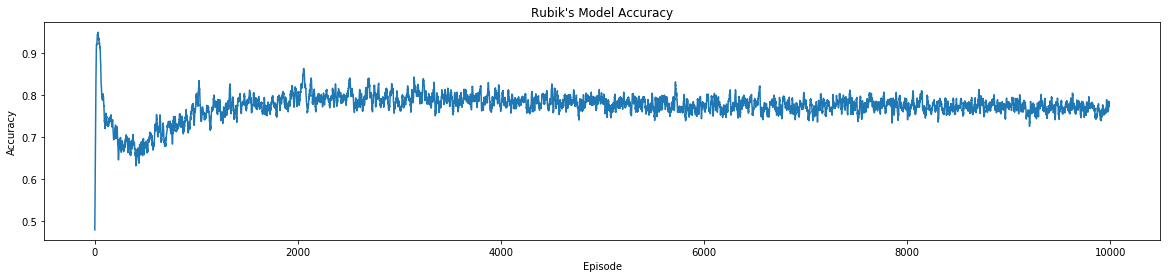

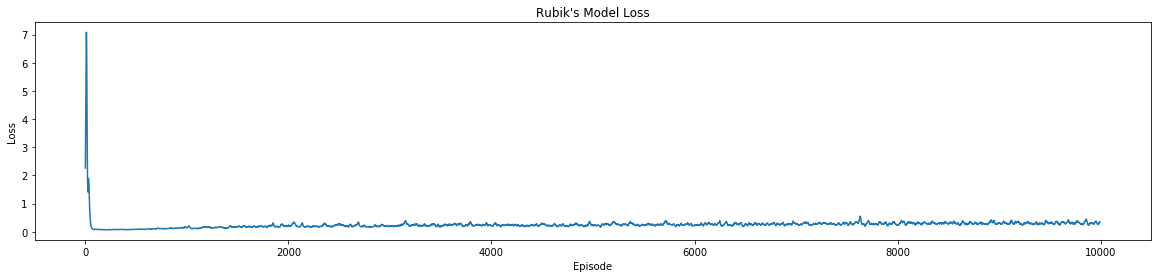

In [28]:
accuracy, loss = CubeUnitTest.extract_acc_loss(history)

# Set up a wider notebook plot display size
#print(matplotlib.rcParams['figure.figsize'])
matplotlib.rcParams['figure.figsize'] = (20, 4)

# Plot with respect to accuracy
plt.figure(1)
plt.plot(accuracy)
plt.title(f'Rubik\'s Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Episode')

# Plot with respect to loss
plt.figure(2)
plt.plot(loss)
plt.title(f'Rubik\'s Model Loss')
plt.ylabel('Loss')
plt.xlabel('Episode')

Running Rubik's solve_cube test...
  WHITE(90) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  GREEN(180) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  GREEN(-90) : UNSOLVED-to-UNSOLVED : reward 4 : solved False
  BLUE(-90) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  BLUE(90) : UNSOLVED-to-UNSOLVED : reward 4 : solved False
  BLUE(-90) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  BLUE(90) : UNSOLVED-to-UNSOLVED : reward 4 : solved False
  BLUE(-90) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  BLUE(90) : UNSOLVED-to-UNSOLVED : reward 4 : solved False
  BLUE(-90) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  BLUE(90) : UNSOLVED-to-UNSOLVED : reward 4 : solved False
  BLUE(-90) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  BLUE(90) : UNSOLVED-to-UNSOLVED : reward 4 : solved False
  BLUE(-90) : UNSOLVED-to-UNSOLVED : reward 3 : solved False
  BLUE(90) : UNSOLVED-to-UNSOLVED : reward 4 : solved False
  BLUE(-90) : UNSOLVED-to-UNSOLVED : reward 3 : solved

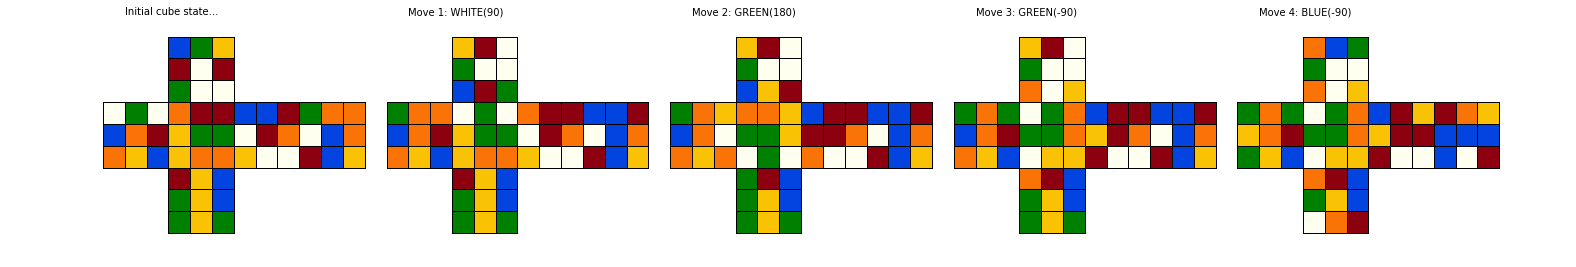

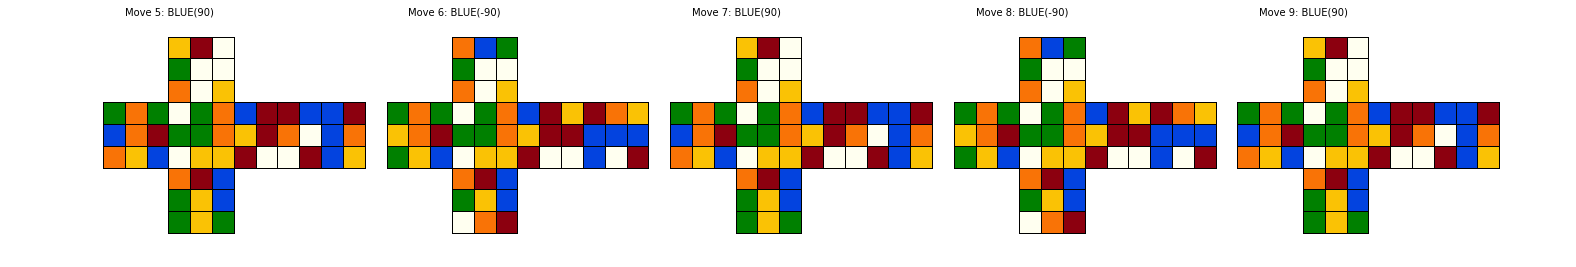

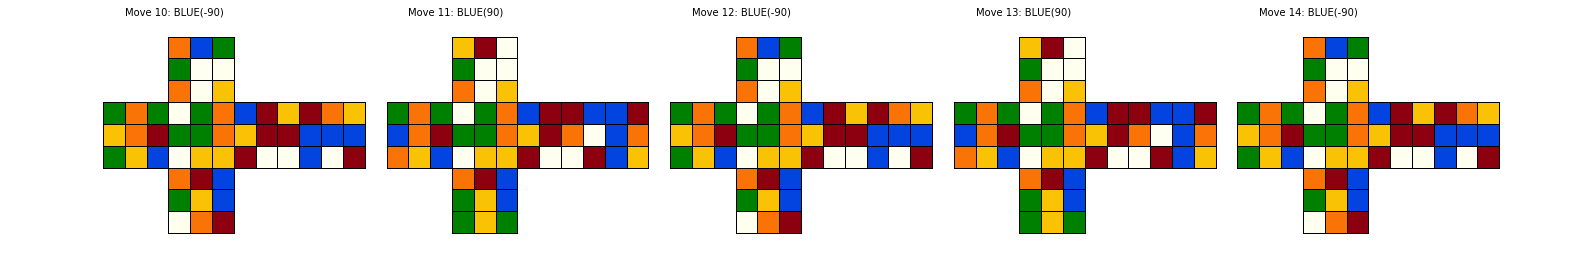

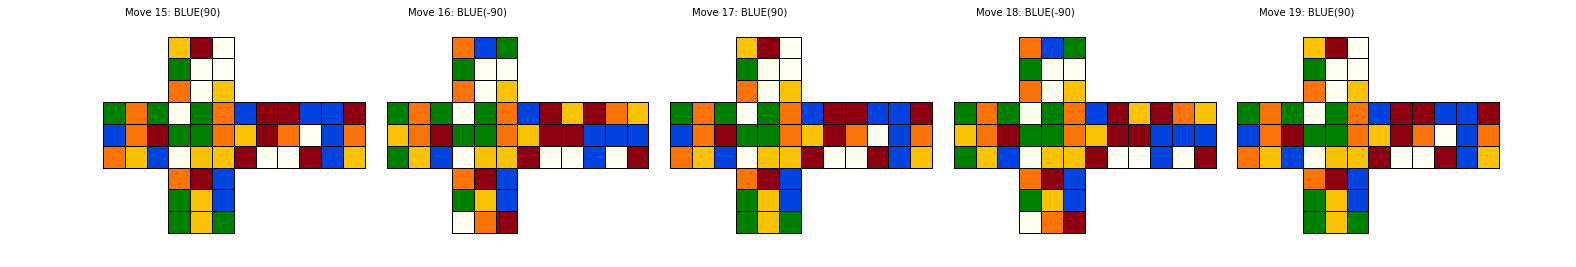

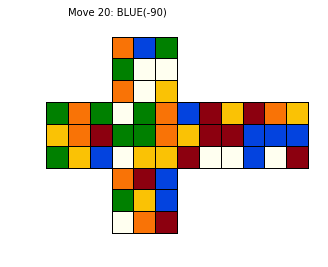

In [38]:
CubeUnitTest().run_cube_test(cube_model)

In [ ]:
%%time
import time

do_train_models = False
unit_test = CubeUnitTest()
mcontrollers = []

if do_train_models:
#{
    for i in range(Cube3D.NCUBELETS):
    #{
        clet_name = tri_color_name(Cube3D.CLET_KEYS[i])
        print(f"\nTraining model for cubelet {i}: {clet_name}")

        start = time.time()
        mctrl = unit_test.train_model_ctrl(i, episodes=10000)
        unit_test.trainer.clet_ctrls.append(mctrl)
        end = time.time()

        minutes = (end - start) // 60
        print(f"Training time for {clet_name}: {minutes} min {int(end-start)%60} sec\n")
    #}
    
    mcontrollers = unit_test.trainer.clet_ctrls
#}
else: mcontrollers = unit_test.trainer.load_models()

In [ ]:
for mctrl in mcontrollers:
#     CubeUnitTest().run_cubelet_test(mctrl)
    CubeUnitTest().run_sequence_test(mctrl)

In [ ]:
# i = next(mctrl.clet_i for mctrl in mcontrollers if mctrl.clet_i == Cube3D.get_clet_index((B,O,Y)))

# clet_name = tri_color_name(Cube3D.CLET_KEYS[i])
# print(f"\nTraining model for cubelet {i}: {clet_name}")

# start = time.time()
# mcontrollers[i] = unit_test.train_model_ctrl(i, episodes=10000)
# end = time.time()

# minutes = (end - start) // 60
# print(f"Training time for {clet_name}: {minutes} min {int(end-start)%60} sec\n")
 

In [ ]:
#CubeUnitTest().run_sequence_test(mcontrollers[i])
#mcontrollers[i].save_model()

In [ ]:
# test_cube = Cube3D()
# test_cube.scramble()

# Overwrite saved model H5 files
#CubeletSolver().save_models(mcontrollers)

In [ ]:
#     ###############################################################
#     # Run some unit tests

#     rubiks_cube = Cube3D()
#     rubiks_cube.scramble()

#     i = np.random.randint(low=0, high=20)
#     cubelet = rubiks_cube.cubelets[i].copy()
#     model_q = trainer.clet_ctrls[i].model

#     solver = CubeletSolver()
#     solved_state = solver.state(solver.solved.get_cubelet(cubelet))

#     print("Running solve_cubelet for", cubelet.name())
#     game = solver.solve_cubelet(model_q, cubelet)

#     print("  Solved state:      ", solved_state)
#     for state, action, reward, state_p in game:
#     #{
#         transition  = "SOLVED-to-" if solver.is_same_state(state, solved_state) else "UNSOLVED-to-"
#         transition += "SOLVED" if solver.is_same_state(state_p, solved_state) else "UNSOLVED"

#         side, angle = CubeletSolver.ACTIONSET[action]
#         print(f"  {color_name(side)}({angle}) : new state {state} : {transition} : reward {reward}")
#     #}

#     print("\n")
#     mnumber = 1
#     cube_view = Cube3DView(rubiks_cube)
#     cube_view.push_snapshot(cubelet, "Initial state...")
#     for state, action, reward, state_p in game:
#     #{
#         solved_text = " : SOLVED!!" if solver.is_same_state(state_p, solved_state) else ""
#         caption = f"Move {mnumber}: {color_name(side)}({angle}){solved_text}"; mnumber += 1

#         side, angle = CubeletSolver.ACTIONSET[action]
#         rubiks_cube.rotate(side, angle)
#         cube_view.push_snapshot(cubelet, caption)
#     #}

#     cube_view.draw_snapshops()
#     #}
# #}

In [ ]:
print("Running solve_cubelet sequence...")

solved_tally = 0
moves_to_solve = []
for i in range(1000):
#{
    rubiks_cube = Cube3D()
    rubiks_cube.scramble()
    solver = CubeletSolver()
    
    j = np.random.randint(low=0, high=20)
    cubelet = rubiks_cube.cubelets[j].copy()
    model_q = trainer.clet_ctrls[j].model
    
    cubelet = rubiks_cube.cubelets[0].copy()
    game = solver.solve_cubelet(model_q, cubelet)
    
    moves = 0
    solved_state = solver.state(solver.solved.get_cubelet(cubelet))
    for _, _, _, state_p in game:
    #{
        moves += 1
        if solver.is_same_state(state_p, solved_state):
            solved_tally += 1
            moves_to_solve.append(moves)
            break
    #}
#}

print("Solution percentage:", solved_tally/1000, ": average moves needed:", np.mean(moves_to_solve))

In [ ]:


cube_view = Cube3DView(rubiks_cube)
cube_view.draw_projection(cubelet)
for state, action, reward, state_p in game:
#{
    transition  = "SOLVED-to-" if solver.is_same_state(state, solved_state) else "UNSOLVED-to-"
    transition += "SOLVED" if solver.is_same_state(state_p, solved_state) else "UNSOLVED"
    
    side, angle = CubeletSolver.ACTIONSET[action]
    print(f"State: {color_name(side)}({angle}) : {transition} : {reward}")
    
    transition  = "SOLVED-to-" if solver.clet_is_solved(cubelet) else "UNSOLVED-to-"
    rubiks_cube.rotate(side, angle)
    transition += "SOLVED" if solver.clet_is_solved(cubelet) else "UNSOLVED"
    print(f"Cube: {color_name(side)}({angle}) : {transition} : {reward}")
    
    print(cubelet)
    print(solver.solved.get_cubelet(cubelet))

    cube_view.draw_projection(cubelet)
#}

# for state, action, reward, state_p in game:
# #{
#     side, angle = CubeletSolver.ACTIONSET[action]
#     rubiks_cube.rotate(side, angle)
#     print(f"Move: {color_name(side)}({angle}) (solved: {solver.clet_is_solved(cubelet)}, reward: {reward})")
#     cube_view.draw_projection(cubelet)
# #}

In [ ]:
solver = CubeletSolver()

# for i in range(100):
# #{

action = np.random.randint(0,len(CubeletSolver.ACTIONSET))
side, angle = CubeletSolver.ACTIONSET[action]

# Cubelet direct
test_cube = Cube3D()
test_cubelet = test_cube.cubelets[0]

a_before = solver.state(test_cubelet)
R = Cube3D.rotation((side, angle))
test_cubelet.apply_rotation(R)
a_after = solver.state(test_cubelet)

# Cube
test_cube2 = Cube3D()
test_cubelet2 = test_cube2.cubelets[0]

b_before = solver.state(test_cubelet2)
test_cube2.rotate(side, angle)
b_after = solver.state(test_cubelet2)

# for clet in self.get_cubelets(side): clet.apply_rotation(Cube3D.rotation((side, angle)))

if not (solver.is_same_state(a_before, b_before) and
        solver.is_same_state(a_after, b_after)):

    print(f"Rotation: {color_name(side)}({angle}) [cubelet moved: {not solver.is_same_state(a_before, a_after)}]")
    print(" Before rotation:", a_before, "cubelet")
    print(" After rotation: ", a_after, "cubelet")
    print(" Before rotation:", b_before, "cube")
    print(" After rotation: ", b_after, "cube")
    
else:
    print(f"SAME for rotation: {color_name(side)}({angle}) [cubelet moved: {not solver.is_same_state(a_before, a_after)}]")
    
# #}


# print(f"State: {color_name(side)}({angle}) : {transition} : {reward}")
    
# transition  = "SOLVED-to-" if solver.clet_is_solved(cubelet) else "UNSOLVED-to-"

    
# rubiks_cube.cubelets[0]
# modinput = solver.shape_cubelet_input(rubiks_cube.cubelets[0])
# Q = model.predict(modinput, batch_size=1)
# print(Q)
# print(np.argmax(Q))
# print(np.max(Q))

In [ ]:
# r1 = Cube3D()
# r1.rotate(WHITE, 90)
# Cube3DView(r1).draw_projection()

# r2 = Cube3D()
# r2.rotate(ORANGE, 90)
# Cube3DView(r2).draw_projection()

# r3 = Cube3D()
# r3.rotate(GREEN, 90)
# Cube3DView(r3).draw_projection()

# r4 = Cube3D()
# r4.rotate(RED, 90)
# Cube3DView(r4).draw_projection()

# r5 = Cube3D()
# r5.rotate(BLUE, 90)
# Cube3DView(r5).draw_projection()

# r6 = Cube3D()
# r6.rotate(YELLOW, 90)
# Cube3DView(r6).draw_projection()

In [ ]:
# tmpcube = Cube3D()

# test = Cube3D.Cubelet(colors=(B,R,W), position=np.array([-1,1,1]))
# test2 = Cube3D.Cubelet(colors=(B,R,W), position=np.array([-1,1,1]))
# print(test)
# print(test2)

# order = np.array([-1,1,1])
# print("Over here:", sum(test.position == order) == 3, "\n")

# test.apply_rotation(tmpcube.rotation[(WHITE, 180)])
# test.apply_rotation(tmpcube.rotation[(GREEN, -90)])
# print(test)

# test2.apply_rotation(tmpcube.rotation[(BLUE, 180)])
# print(test2)

# print("Here:", test.orient[:,2])
# print("Here:", np.flatnonzero(test.orient[:,2] == 1)[0])
# print("Here:", test2.orient[:,2])
# print("Here:", np.flatnonzero(test2.orient[:,2] == -1)[0], "\n")

# test3 = Cube3D.Cubelet(colors=(G,R,0), position=np.array([1,1,0]))
# test4 = Cube3D.Cubelet(colors=(G,R,0), position=np.array([1,1,0]))
# print(test3)
# print(test4)

# print("Over here:", test3.position == order, "\n")

# test3.apply_rotation(tmpcube.rotation[(RED, 90)])
# test3.apply_rotation(tmpcube.rotation[(YELLOW, 180)])
# test3.apply_rotation(tmpcube.rotation[(ORANGE, 90)])
# print(test3)

# test4.apply_rotation(tmpcube.rotation[(GREEN, 90)])
# test4.apply_rotation(tmpcube.rotation[(WHITE, 180)])
# test4.apply_rotation(tmpcube.rotation[(BLUE, 90)])
# print(test4)


In [ ]:
# 20 cubelets
# index = 1
# corners = [C1,C2,C3,C4,C5,C6,C7,C8]
# for c in corners: print(f"C{index} = \'{numb_letr_map[c[0]]}{numb_letr_map[c[1]]}{numb_letr_map[c[2]]}\'"); index +=1

# index = 1
# edges = [E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12]
# for e in edges: print(f"E{index} = \'{numb_letr_map[e[0]]}{numb_letr_map[e[1]]}\'"); index += 1

# # 20 positions
# L1  = (1,1)
# L2  = (1,2)
# L3  = (1,3)
# L4  = (1,4)
# L5  = (1,5)
# L6  = (1,6)
# L7  = (1,7)
# L8  = (1,8)
# L9  = (2,1)
# L10 = (2,2)
# L11 = (2,3)
# L12 = (2,4)
# L13 = (3,1)
# L14 = (3,2)
# L15 = (3,3)
# L16 = (3,4)
# L17 = (3,5)
# L18 = (3,6)
# L19 = (3,7)
# L20 = (3,8)


# # Top layer
# Pc1  = (1,-1,1)
# Pc2  = (-1,-1,1)
# Pc3  = (-1,1,1)
# Pc4  = (1,1,1)

# Pe1  = (0,-1,1)
# Pe2  = (-1,0,1)
# Pe3  = (0,1,1)
# Pe4  = (1,0,1)

# # Middle layer
# Pe5  = (1,-1,0)
# Pe6  = (-1,-1,0)
# Pe7  = (-1,1,0)
# Pe8  = (1,1,0)

# # Bottom layer
# Pc5  = (1,-1,-1)
# Pc6  = (-1,-1,-1)
# Pc7  = (-1,1,-1)
# Pc8  = (1,1,-1)

# Pe9  = (0,-1,-1)
# Pe10 = (-1,0,-1)
# Pe11 = (0,1,-1)
# Pe12 = (1,0,-1)

# for pos, nm in zip([Pc1,Pc2,Pc3,Pc4,Pe1,Pe2,Pe3,Pe4,Pe5,Pe6,Pe7,Pe8,Pc5,Pc6,Pc7,Pc8,Pe9,Pe10,Pe11,Pe12],
#                    ['Pc1','Pc2','Pc3','Pc4','Pe1','Pe2','Pe3','Pe4','Pe5','Pe6','Pe7','Pe8','Pc5','Pc6','Pc7','Pc8','Pe9','Pe10','Pe11','Pe12']):
    
#     print(f"{nm} = np.array([{pos[0]},{pos[1]},{pos[2]}])");


# for nm, pos in zip([C1,C2,C3,C4, E1,E2,E3,E4, E5,E6,E7,E8, C5,C6,C7,C8, E9,E10,E11,E12],
#                    [Pc1,Pc2,Pc3,Pc4,Pe1,Pe2,Pe3,Pe4,Pe5,Pe6,Pe7,Pe8,Pc5,Pc6,Pc7,Pc8,Pe9,Pe10,Pe11,Pe12]):
    
#     print(f"cubelets.append(Cubelet(name=\'{nm}\', position=np.array([{pos[0]},{pos[1]},{pos[2]}])))")
    
    

# # Names ############

# # Top layer
# C1  = 'GOW'
# C2  = 'BOW'
# C3  = 'BRW'
# C4  = 'GRW'

# E1  = '_OW'
# E2  = 'B_W'
# E3  = '_RW'
# E4  = 'G_W'

# # Middle layer
# E5  = 'GO_'
# E6  = 'BO_'
# E7  = 'BR_'
# E8  = 'GR_'

# # Bottom layer
# C5  = 'GOY'
# C6  = 'BOY'
# C7  = 'BRY'
# C8  = 'GRY'

# E9  = '_OY'
# E10 = 'B_Y'
# E11 = '_RY'
# E12 = 'G_Y'
    
# # Positions ############

# # Top layer
# Pc1  = np.array([1,-1,1])
# Pc2  = np.array([-1,-1,1])
# Pc3  = np.array([-1,1,1])
# Pc4  = np.array([1,1,1])

# Pe1  = np.array([0,-1,1])
# Pe2  = np.array([-1,0,1])
# Pe3  = np.array([0,1,1])
# Pe4  = np.array([1,0,1])

# # Middle layer
# Pe5  = np.array([1,-1,0])
# Pe6  = np.array([-1,-1,0])
# Pe7  = np.array([-1,1,0])
# Pe8  = np.array([1,1,0])

# # Bottom layer
# Pc5  = np.array([1,-1,-1])
# Pc6  = np.array([-1,-1,-1])
# Pc7  = np.array([-1,1,-1])
# Pc8  = np.array([1,1,-1])

# Pe9  = np.array([0,-1,-1])
# Pe10 = np.array([-1,0,-1])
# Pe11 = np.array([0,1,-1])
# Pe12 = np.array([1,0,-1])

# # Rotations ############

# orientation = np.array([0,0,1])
# for rad, deg in zip([math.pi/2, -math.pi/2, math.pi], [90, -90, 180]):
# #{
#     c = round(math.cos(rad))
#     s = round(math.sin(rad))
    
#     Rx = np.array([[1,0,0],[0,c,-s],[0,s,c]])
#     Ry = np.array([[c,0,s],[0,1,0],[-s,0,c]])
#     Rz = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    
# #     for pos in [Pc1,Pc2,Pc3,Pc4,Pe1,Pe2,Pe3,Pe4,Pe5,Pe6,Pe7,Pe8,Pc5,Pc6,Pc7,Pc8,Pe9,Pe10,Pe11,Pe12, orientation]:
# #         print(Rx.dot(pos))
# #         print(Ry.dot(pos))
# #         print(Rz.dot(pos))
        
# #     print(f"cos({deg}) {c}")
# #     print(f"sin({deg}) {s}")
# #     print(f"Rx({deg})\n {Rx}")
# #     print(f"Ry({deg})\n {Ry}")
# #     print(f"Rz({deg})\n {Rz}")
# #}


In [ ]:
# loss_history = np.zeros((episodes,))
# step_history = np.zeros((3,))
# step_history[stp] = np.mean(np.square(Q - Q_target))
# loss_history[i] = np.mean(step_history)
    
#     def get_rotation(self, action):
#         side, angle = CubeletSolver.ACTIONSET[action]
#         return solved.rotation[(side, angle)]
    
#     def run_cubelet_policy(self, cubelet, model):
#     #{
#         game = []
#         clet = cubelet.copy()
#         solved = self.solved.cubelets.get_cubelet(clet)
        
#         for i in range(3):
#         #{
#             state = shape_cubelet_input(clet)
#             Q = model.predict(state, batch_size=1)
#             rot_action = self.get_rotation(np.argmax(Q))
#             clet.apply_rotation(rot_action)
#             reward = 1 if solved.matches(clet) else 0
#             game.append((state, Q, reward))
#         #}

#         return game
#     #}
    
    #     np.power(gamma,i)*

#     def solve_cubelet(self, cube, cubelet):
#     #{
#         i = np.flatnonzero(np.equal(self.solved.cubelets, cubelet))[0]
#         solved = self.solved.cubelets[i].matches(cubelet)
      
#         solutions, movestack = [],[]
        
#         angle = [90, -90, 180]        
#         for depth in range(2):
#         #{
            
#             for sd in SIDES:
#                 for ang in [90, -90, 180]:
#                     cube.rotate(sd, 90 if ang < 0.5 else -90)
#         #}
#     #}
#}

#     def run_policy(self, cube, iclet, model, episodes=10000):
#     #{
#         cube = Cube3D()
#         for i in range (episodes):
#         #{
#             cube.scramble()
#             for j in range(20):
#                 modinput = self.shape_cubelet_input(cube.cubelets[iclet])
#                 model.predict(modinput, batch_size=1)
#                 # Step cube forward with that action
#                 reward = self.step_env_forward(action, cube, iclet)
                
#         #}
    
#     #}

#                 state = shape_cubelet_input(clet)
#                 action = policy()
#                 Qs = model.predict(state, batch_size=1)
#                 rotation = self.get_rotation(np.argmax(Q))
#                 clet.apply_rotation(rotation)
#                 reward = 1 if solved.matches(clet) else 0
                
#                 self.step_cubelet(action, cubelet)
                                
#                 game.append((state, Q, reward))
            
#                 state = self.shape_cubelet_input(cube.cubelets[iclet])
#                 Q = model.predict(state, batch_size=1)
#                 action = np.argmax(Q)
                
#                 # Step cube forward with that action
#                 reward = self.step_env_forward(action, cube, iclet)                
                
#                 # Updated cube-state, so model.predict(...) is Q(s',a')
#                 state = self.shape_cubelet_input(cube.cubelets[iclet])
#                 Q_next = model.predict(state, batch_size=1)
                
#                 # Calculate loss and update model
#                 target = reward + gamma * np.max(Q_next)
#                 Q_target = np.zeros((1,18))
#                 Q_target[0,action] = target


In [ ]:
a = [1,2,3,4,5,6,7,8,9]
# print(type(a))
# np.reshape(a, (3,3))

np.nonzero(np.equal(a,5))
np.flatnonzero(np.equal(a,5))[0]

print(next(x for x in a if x == 7))

a = np.array([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([11,22,33])

c = np.concatenate((b, a), axis=None)

print(c.shape)
print(c)

c = c.reshape((1,-1))
print(c.shape)
print(c)

In [ ]:
a = np.array([[0,0,-1],[0,-1,0],[1,0,0]])
b = np.array([[0,0,1],[0,-1,0],[1,0,0]])
print(a)
print(a[:,2])
print(a[2,:])

print(sum(sum(a == b)) == 9)

In [ ]:
a = [1,2,3,4,5,6,7,8,9]

mtchpt = next(x for x in a if x == 5)
print(mtchpt)

print(np.power(mtchpt, 0))

# moves = [(sd,ang) for sd in SIDES for ang in [90,-90,180]]
# print(moves)

# a,b = moves[2]

# print(a, "and", b)
# print(moves[2])

In [ ]:
t = (11,22,33)
g = np.mean(t)
(g,g,g)

l = [11,22,33]
l2 = [11,22,33]

# print(l == l2, l == t)

for ex in [0,11,22,33,44]:
    print(next((True for v in l2 if v == ex), False))

print(0.98 * 0.8)
print(.17 * 0.8)



In [ ]:
import time

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_average_b(values, n=10):
    return [np.mean(values[i-n:i]) for i in range(n, len(values)+1)]

a = [1,2,3,4,5,6,7,8,9]
b = a
print(a)
print(moving_average(a, 3))
print(id(a) == id(b))

In [ ]:
avg_diff = []
for i in range(10):
#{
    size = 100000
    big_list = [np.random.random() for i in range(size)]

    start = time.time()
    moving_average(big_list)
    end = time.time()
    w_cumsum = end - start
    #print(f"\nExecution time w/cumsum: {end - start} sec")

    start = time.time()
    moving_average_b(big_list)
    end = time.time()
    wo_cumsum = end - start
    #print(f"Execution time w/o sumsum: {end - start} sec")
    
    avg_diff.append(wo_cumsum/w_cumsum)
#}

print(f"\nWith cumsum is: {np.mean(avg_diff)} times faster")

In [ ]:
# def state(self, cubelet):
#         return np.concatenate((cubelet.position, cubelet.orient), axis=None).reshape((1,12))

scube = Cube3D()
for clet in scube.cubelets:
    print(solver.state(clet), "\n", clet)
    
    vals = solver.state(clet).reshape(12,)
    pos = np.array(vals[0:3])
    ori = np.array(vals[3:].reshape(3,3))
    print("Pos:", pos)
    print("Ori:", ori)
    
#     f"Cube3D.solved_state[(G,O,W)] = np.array(
#     #print(solver.state(clet).shape)
#    print(f"Cube3D.solved_state[({color_letr(clet.colors[0])},{color_letr(clet.colors[1])},{color_letr(clet.colors[2])})] = np.array({solver.state(clet)})")


    

In [ ]:
# counter = {}
# a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# for i in range(200000): 
#     value = np.random.choice(a)
#     counter[value] = counter.get(value, 0) + 1

# a_holder = [[]]
# def push_test(value):
# #{
#     if len(a_holder[len(a_holder)-1]) > 4:
#          a_holder.append([])
    
#     a_holder[len(a_holder)-1].append(value)
# #}

# a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# for val in a: push_test(val)
    
# print(a_holder)
    
#     ncols = ((len(a)-1) % 5) + 1
#     nrows = (len(a) // 6) + 1

# for k in sorted(counter): print(k, ":", counter[k])
    
# 200000 / 5000
# value = True
# value
# not value

# import numpy as np
# np.random.choice([90, -90, 180], size=64)

# a = 5
# b = (3,2,1)
# print(type(a), type(b))
# print(type(a) is int, type(b) is tuple)

a = np.array([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]])
c = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
print(a.shape)
print(c.shape)

b = np.ndarray.flatten(a)
print(b.shape)

d = np.ndarray.flatten(c)
print(d.shape)

f = ['a','b','c']

np.concatenate([b,c,f])

In [ ]:
testd = {'one':1, 'two':2, 'three':3, 'four':4}
for k,v in sorted(testd.items()): print(k, v)

In [ ]:
a = 2
b = [4,5,6,7,8,9]

a = [a] + b
print("A is:", a)
# a.extend(b)
# a

In [ ]:
class Parent:
#{  
    @staticmethod
    def does_something_stat():
        print('class Parent: did something static')
        
    def does_something(self):
        print('class Parent: did something instance')
#}

In [ ]:
class Child(Parent):
#{
    def does_something(self):
        super().does_something()
        print('class Child: did something')
#}

Parent.does_something_stat()
kid = Child()
kid.does_something()
print(kid.__class__())
print(isinstance(kid, Parent))

In [ ]:
def fcn(a,b):
    print(a + b)

c_tuple = (5,3)
print(c_tuple)
print(*c_tuple)
fcn(*c_tuple)